In [1]:
# We used Google Drive to load the CSV files
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# All the necessary imports are in this cell
from pathlib import Path
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import zscore
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.model_selection import (
    TimeSeriesSplit,
    StratifiedKFold,
    train_test_split,
    cross_val_score,
    cross_val_predict,
)
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import (
    r2_score,
    mean_absolute_error,
    accuracy_score,
    f1_score,
    balanced_accuracy_score,
    classification_report,
    confusion_matrix,
    make_scorer,
)

In [3]:
# Created a helper function to load a CSV and clean the data
def load_solar_file(filepath):
    df = pd.read_excel(filepath, sheet_name=None)
    sheet = list(df.keys())[0]
    df = df[sheet]
    df = df.set_index(df.columns[0]).T  # Transpose and fix index
    df.index.name = 'timestamp'
    df = df.replace("--", np.nan).astype(float)
    return df

# The paths to our datasets
base_path = '/content/drive/My Drive/ColabNotebooks/'

# We load each dataset into a variable
grid_voltage = load_solar_file(base_path + 'GridSensor1.xlsx')
grid_power = load_solar_file(base_path + 'GridSensor2.xlsx')
inverter_30kw = load_solar_file(base_path + '30kwInverter.xlsx')
inverter_40kw = load_solar_file(base_path + '40kwInverter.xlsx')

# We combine them to a single dataset
merged_df = pd.concat(
    [grid_voltage, grid_power, inverter_30kw, inverter_40kw],
    axis=1,
    keys=['grid_voltage', 'grid_power', 'inverter_30kw', 'inverter_40kw']
)


/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/tmp/ipython-input-2264739986.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df = df.replace("--", np.nan).astype(float)
/usr/local/lib/python3.12/dist-packages/openpyxl/styles/stylesheet.py:237: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")
/tmp/ipython-input-2264739986.py:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_obje

In [4]:
merged_df.head()  # preview of the first few rows

grid_voltage                             \
Unnamed: 0       Meter-1_AB line voltage(V) Meter-1_BC line voltage(V)   
timestamp                                                                
2025-01-01 00:00                     392.99                     392.68   
2025-01-01 00:05                     392.45                     392.27   
2025-01-01 00:10                     392.56                     392.63   
2025-01-01 00:15                     393.35                     393.27   
2025-01-01 00:20                     391.48                     391.05   

                                             \
Unnamed: 0       Meter-1_CA line voltage(V)   
timestamp                                     
2025-01-01 00:00                     392.35   
2025-01-01 00:05                     392.74   
2025-01-01 00:10                     393.19   
2025-01-01 00:15                     392.58   
2025-01-01 00:20                     392.84   

                                                     \
Unnamed: 0       Meter-1_Voltage/Phase A voltage(V)   
timestamp                                             
2025-01-01 00:00                             226.27   
2025-01-01 00:05                             226.56   
2025-01-01 00:10                             226.64   
2025-01-01 00:15                             226.39   
2025-01-01 00:20                             226.67   

                                                                        \
Unnamed: 0       Meter-1_Phase B voltage(V) Meter-1_Phase C voltage(V)   
timestamp                                                                
2025-01-01 00:00                     226.14                     226.43   
2025-01-01 00:05                     226.59                     226.58   
2025-01-01 00:10                     226.61                     226.86   
2025-01-01 00:15                     226.50                     226.58   
2025-01-01 00:20                     226.43                     226.47   

                                                     \
Unnamed: 0       Meter-1_Current/Phase A current(A)   
timestamp                                             
2025-01-01 00:00                               29.7   
2025-01-01 00:05                               25.6   
2025-01-01 00:10                               25.5   
2025-01-01 00:15                               25.7   
2025-01-01 00:20                               23.1   

                                                                        \
Unnamed: 0       Meter-1_Phase B current(A) Meter-1_Phase C current(A)   
timestamp                                                                
2025-01-01 00:00                       23.7                       29.9   
2025-01-01 00:05                       21.1                       28.7   
2025-01-01 00:10                       21.7                       29.1   
2025-01-01 00:15                       21.0                       27.6   
2025-01-01 00:20                       21.7                       28.0   

                                          ...                inverter_40kw  \
Unnamed: 0       Meter-1_Active power(W)  ... Inverter-1-40kW_Power factor   
timestamp                                 ...                                
2025-01-01 00:00                -17780.0  ...                          0.0   
2025-01-01 00:05                -16276.0  ...                          NaN   
2025-01-01 00:10                -16554.0  ...                          NaN   
2025-01-01 00:15                -15776.0  ...                          NaN   
2025-01-01 00:20                -15630.0  ...                          NaN   

                                                     \
Unnamed: 0       Inverter-1-40kW_Grid frequency(Hz)   
timestamp                                             
2025-01-01 00:00                                0.0   
2025-01-01 00:05                                NaN   
2025-01-01 00:10                                NaN   
2025-01-01 00:15                      

In [5]:
merged_df.index = pd.to_datetime(merged_df.index)

<Figure size 1000x500 with 0 Axes>

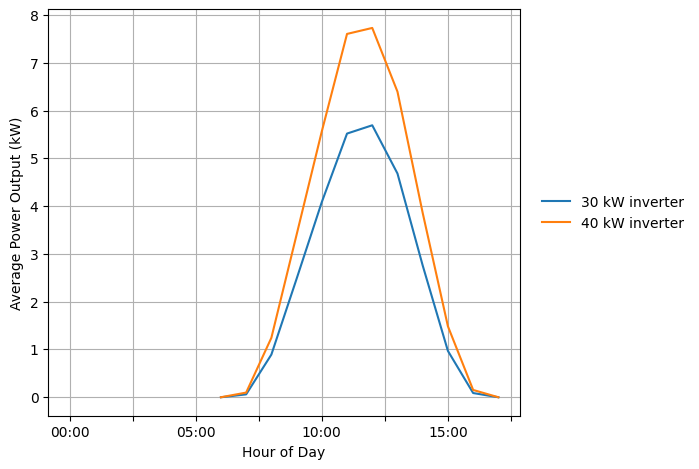

<Figure size 1000x500 with 0 Axes>

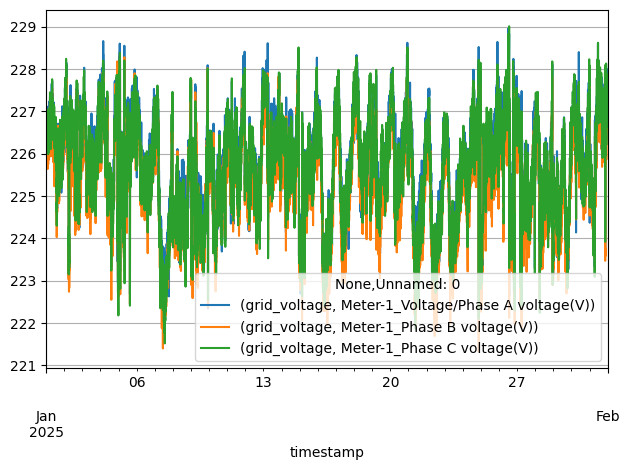

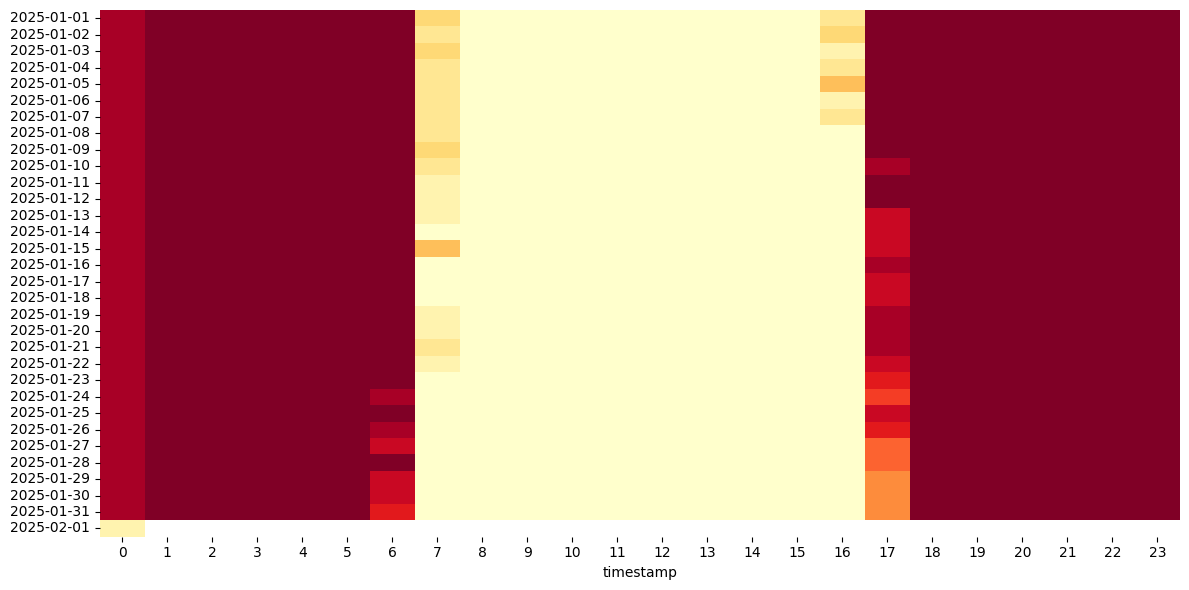

<Figure size 1000x500 with 0 Axes>

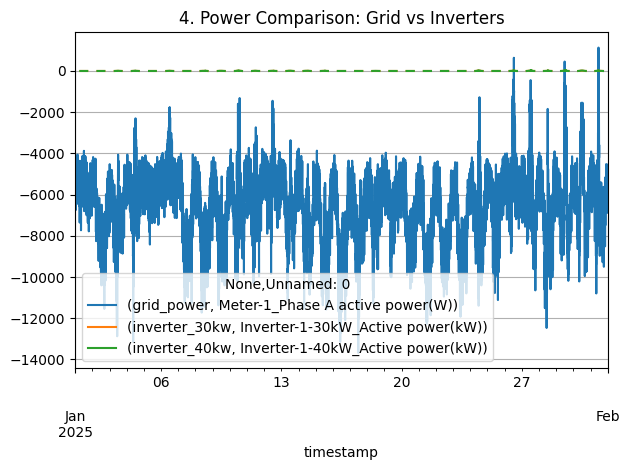

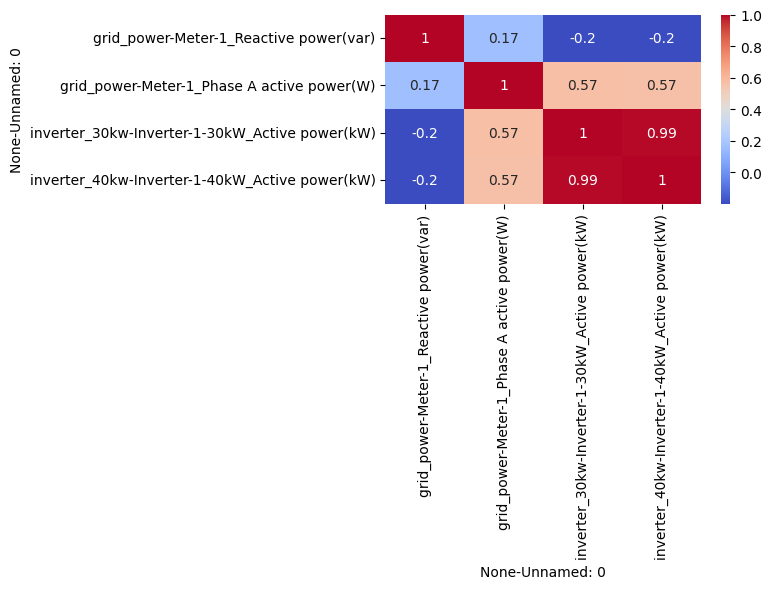

<Figure size 1000x500 with 0 Axes>

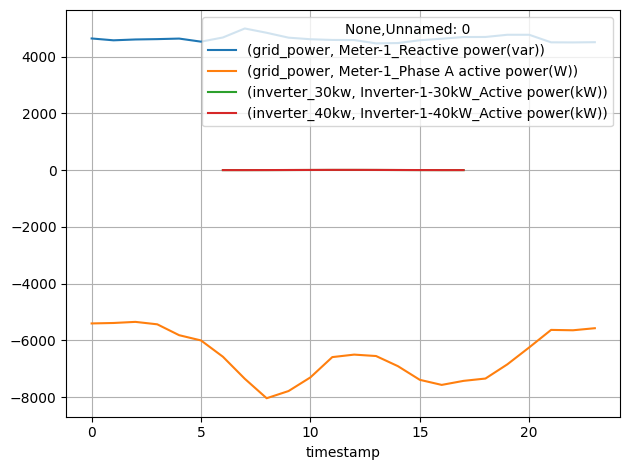

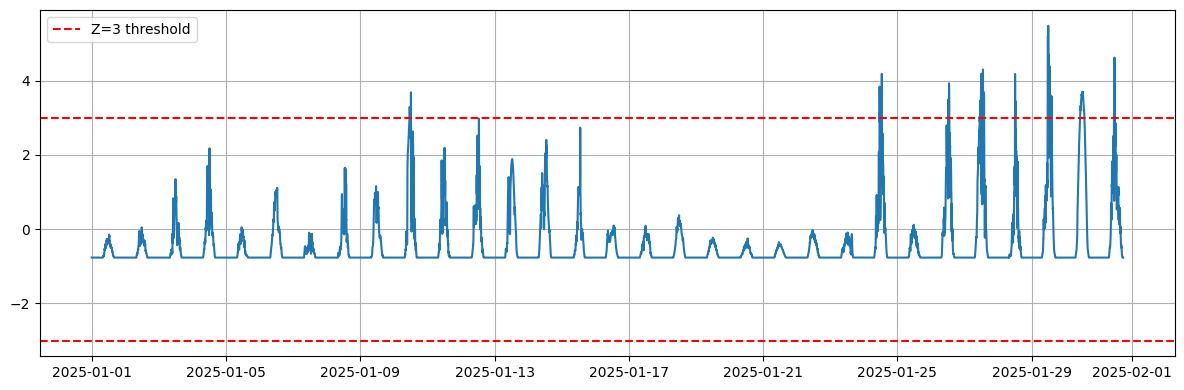

In [6]:
# Ensuring datetime index
merged_df.index = pd.to_datetime(merged_df.index)

# We ensure column hierarchy
if not isinstance(merged_df.columns, pd.MultiIndex):
    merged_df.columns = pd.MultiIndex.from_tuples([tuple(col.split(".", 1)) for col in merged_df.columns])

# 1. Avg Daily Production Profile
plt.figure(figsize=(10, 5))

hourly_avg = merged_df.groupby(merged_df.index.hour)[
    [("inverter_30kw", "Inverter-1-30kW_Active power(kW)"),
     ("inverter_40kw", "Inverter-1-40kW_Active power(kW)")]
].mean()
hourly_avg.index = [f"{int(h):02d}:00" for h in hourly_avg.index]

# Shortenened legend labels on a reviewer's request
hourly_avg.columns = ["30 kW inverter", "40 kW inverter"]

ax = hourly_avg.plot(grid=True)
ax.set_title("")
ax.set_xlabel("Hour of Day")
ax.set_ylabel("Average Power Output (kW)")
ax.legend(loc="center left", bbox_to_anchor=(1.02, 0.5), frameon=False)
plt.tight_layout()
plt.subplots_adjust(right=0.82)
plt.show()


# 2. Grid Phase Voltages
plt.figure(figsize=(10, 5))
merged_df[[("grid_voltage", "Meter-1_Voltage/Phase A voltage(V)"),
           ("grid_voltage", "Meter-1_Phase B voltage(V)"),
           ("grid_voltage", "Meter-1_Phase C voltage(V)")]].plot()
plt.grid(True)
plt.tight_layout()
plt.show()

# 3. Missing Data Heatmap (30kW Inverter)
plt.figure(figsize=(12, 6))
missing_hour_day = merged_df[("inverter_30kw", "Inverter-1-30kW_Active power(kW)")].isna()
missing_matrix = missing_hour_day.groupby([merged_df.index.date, merged_df.index.hour]).sum().unstack()
sns.heatmap(missing_matrix, cmap="YlOrRd", cbar=False)
plt.tight_layout()
plt.show()

# 4. Power Output Comparison
plt.figure(figsize=(10, 5))
merged_df[[("grid_power", "Meter-1_Phase A active power(W)"),
           ("inverter_30kw", "Inverter-1-30kW_Active power(kW)"),
           ("inverter_40kw", "Inverter-1-40kW_Active power(kW)")]].plot()
plt.title("4. Power Comparison: Grid vs Inverters")
plt.grid(True)
plt.tight_layout()
plt.show()

# 5. Correlation Matrix
plt.figure(figsize=(8, 6))
selected_cols = merged_df[[("grid_power", "Meter-1_Reactive power(var)"),
                           ("grid_power", "Meter-1_Phase A active power(W)"),
                           ("inverter_30kw", "Inverter-1-30kW_Active power(kW)"),
                           ("inverter_40kw", "Inverter-1-40kW_Active power(kW)")]]
corr = selected_cols.corr()
sns.heatmap(corr, annot=True, cmap="coolwarm")
plt.tight_layout()
plt.show()

# 6. Hourly Mean Profile
plt.figure(figsize=(10, 5))
hourly_mean = selected_cols.groupby(merged_df.index.hour).mean()
hourly_mean.plot(title="", grid=True)
plt.tight_layout()
plt.show()

# 7. Z-score for Anomaly Detection (40kW)
plt.figure(figsize=(12, 4))
inverter_40kw = merged_df[("inverter_40kw", "Inverter-1-40kW_Active power(kW)")].dropna()
z = zscore(inverter_40kw)
plt.plot(inverter_40kw.index, z)
plt.axhline(y=3, color='r', linestyle='--', label='Z=3 threshold')
plt.axhline(y=-3, color='r', linestyle='--')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [7]:
merged_df[("time", "hour")] = merged_df.index.hour
merged_df[("time", "dayofweek")] = merged_df.index.dayofweek
merged_df[("time", "month")] = merged_df.index.month
merged_df[("time", "is_weekend")] = merged_df.index.dayofweek.isin([5, 6]).astype(int)
merged_df[("time", "time_index")] = range(len(merged_df))

In [8]:
merged_df_clean = merged_df.dropna(subset=[
    ("inverter_30kw", "Inverter-1-30kW_Active power(kW)"),
    ("inverter_40kw", "Inverter-1-40kW_Active power(kW)")
])

In [9]:
# We defined all of the needed columns (features + target)
all_needed_cols = [
    ("grid_voltage", "Meter-1_Voltage/Phase A voltage(V)"),
    ("grid_power", "Meter-1_Phase A active power(W)"),
    ("inverter_30kw", "Inverter-1-30kW_Active power(kW)"),
    ("time", "hour"),
    ("time", "dayofweek"),
    ("time", "is_weekend"),
    ("inverter_40kw", "Inverter-1-40kW_Active power(kW)")  # target
]

# Dropping any rows with missing values
df_clean = merged_df.dropna(subset=all_needed_cols)

# Split features and target
X = df_clean.drop(columns=("inverter_40kw", "Inverter-1-40kW_Active power(kW)"))
y = df_clean[("inverter_40kw", "Inverter-1-40kW_Active power(kW)")]


In [10]:
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)

# Evaluate Regression
y_pred = model.predict(X_test)
print("R²:", r2_score(y_test, y_pred))
print("MAE:", mean_absolute_error(y_test, y_pred))


R²: 0.9945896348958254
MAE: 0.1215397877984081


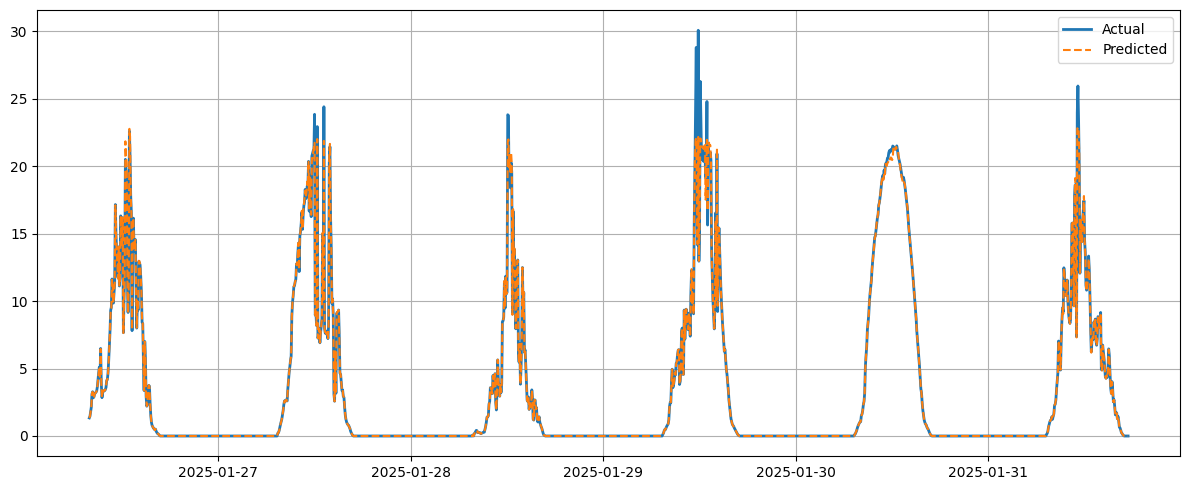

In [11]:
plt.figure(figsize=(12, 5))
plt.plot(y_test.index, y_test, label="Actual", linewidth=2)
plt.plot(y_test.index, y_pred, label="Predicted", linestyle="--")
plt.title("")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


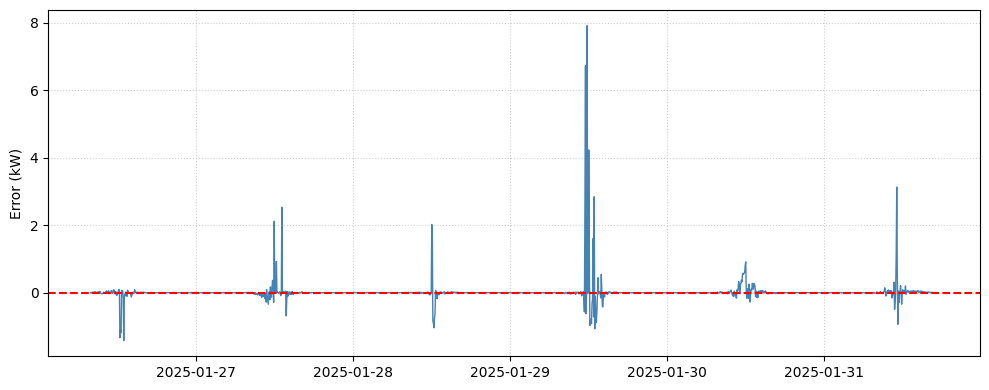

In [12]:
residuals = y_test - model.predict(X_test)
plt.figure(figsize=(10, 4))
plt.plot(y_test.index, residuals, lw=1.0, color="steelblue")
plt.title("")
plt.axhline(0, color='red', linestyle='--')
plt.ylabel("Error (kW)")
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()

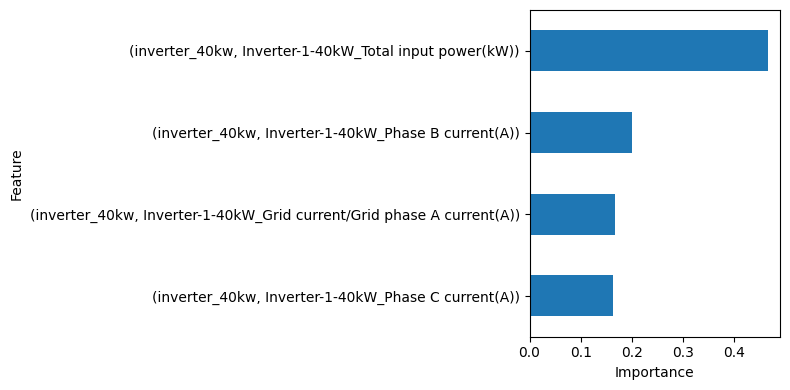

In [13]:
# Plotting feature importances
importances = model.feature_importances_
features = X.columns
importance_df = pd.Series(importances, index=features).sort_values()

top_features = importance_df.tail(4)

top_features.plot(kind='barh', figsize=(8, 4), title="")
plt.ylabel("Feature")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()


In [14]:
# Predicting and calculating residuals
y_pred = model.predict(X_test)
residuals = y_test - y_pred

# Calculating Z-scores of residuals
from scipy.stats import zscore
residual_z = zscore(residuals)

# Flagging anomalies where |Z| > 3
anomalies = np.abs(residual_z) > 3
anomaly_times = y_test.index[anomalies]

# Display summary
print(f"Detected {anomalies.sum()} anomalies")


Detected 11 anomalies


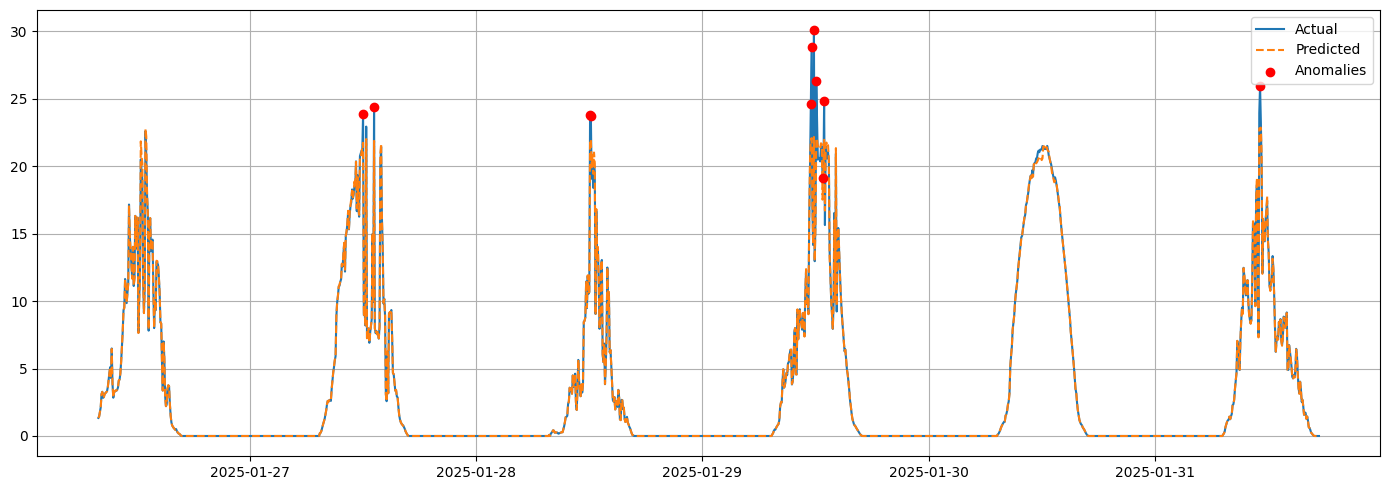

In [15]:
plt.figure(figsize=(14, 5))
plt.plot(y_test.index, y_test, label="Actual")
plt.plot(y_test.index, y_pred, label="Predicted", linestyle="--")

# Highlight anomalies
plt.scatter(anomaly_times, y_test[anomalies], color='red', label="Anomalies", zorder=5)
plt.title("")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [16]:
target_30kw = ("inverter_30kw", "Inverter-1-30kW_Active power(kW)")
feature_cols_30kw = [
    ("grid_voltage", "Meter-1_Voltage/Phase A voltage(V)"),
    ("grid_power", "Meter-1_Phase A active power(W)"),
    ("inverter_40kw", "Inverter-1-40kW_Active power(kW)"),
    ("time", "hour"),
    ("time", "dayofweek"),
    ("time", "is_weekend"),
]

all_needed_30kw = feature_cols_30kw + [target_30kw]
df_30kw = merged_df.dropna(subset=all_needed_30kw)

X_30 = df_30kw[feature_cols_30kw]
y_30 = df_30kw[target_30kw]

In [17]:
X_train_30, X_test_30, y_train_30, y_test_30 = train_test_split(X_30, y_30, shuffle=False, test_size=0.2)

model_30 = RandomForestRegressor(n_estimators=100, random_state=42)
model_30.fit(X_train_30, y_train_30)

y_pred_30 = model_30.predict(X_test_30)


In [18]:

residuals_30 = y_test_30 - y_pred_30
z_30 = zscore(residuals_30)
anomalies_30 = np.abs(z_30) > 3
anomaly_times_30 = y_test_30.index[anomalies_30]

print(f"Detected {anomalies_30.sum()} anomalies for 30kW inverter")


Detected 15 anomalies for 30kW inverter


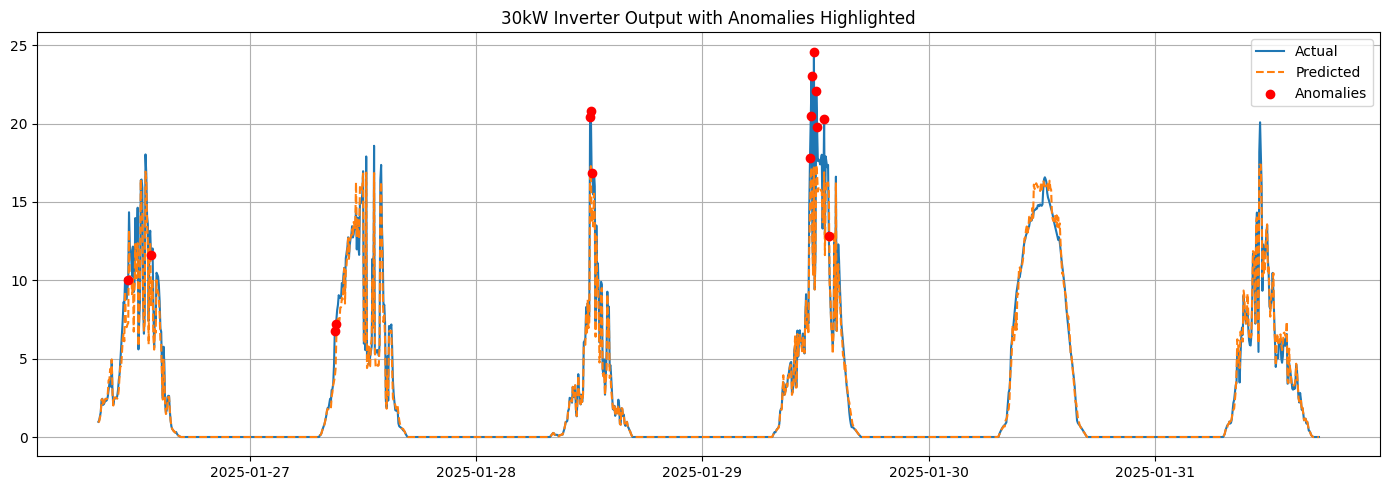

In [19]:
plt.figure(figsize=(14, 5))
plt.plot(y_test_30.index, y_test_30, label="Actual")
plt.plot(y_test_30.index, y_pred_30, label="Predicted", linestyle="--")
plt.scatter(anomaly_times_30, y_test_30[anomalies_30], color='red', label="Anomalies", zorder=5)
plt.title("30kW Inverter Output with Anomalies Highlighted")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


<Axes: title={'center': 'Grid Phase Voltages Over Time'}, xlabel='timestamp'>

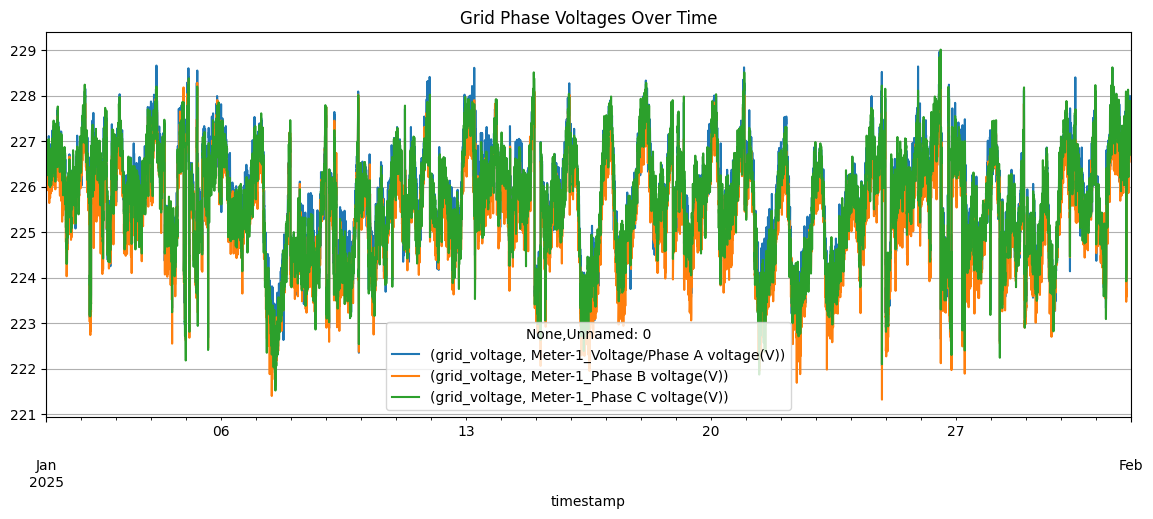

In [20]:
# Plot grid phase voltages
merged_df[[("grid_voltage", "Meter-1_Voltage/Phase A voltage(V)"),
           ("grid_voltage", "Meter-1_Phase B voltage(V)"),
           ("grid_voltage", "Meter-1_Phase C voltage(V)")]].plot(figsize=(14,5), title="Grid Phase Voltages Over Time", grid=True)


In [21]:
z_reactive = zscore(merged_df[("grid_power", "Meter-1_Reactive power(var)")].dropna())
anomalies_reactive = np.abs(z_reactive) > 3
print(f"Reactive power anomalies: {anomalies_reactive.sum()}")

Reactive power anomalies: 23


In [22]:
merged_df[("grid_power", "Phase A power rolling mean (15m)")] = merged_df[("grid_power", "Meter-1_Phase A active power(W)")].rolling(3).mean()
merged_df[("grid_voltage", "Voltage A rolling std (15m)")] = merged_df[("grid_voltage", "Meter-1_Voltage/Phase A voltage(V)")].rolling(3).std()

In [23]:
cols = [
    ("grid_voltage", "Meter-1_Voltage/Phase A voltage(V)"),
    ("grid_voltage", "Meter-1_Phase B voltage(V)"),
    ("grid_voltage", "Meter-1_Phase C voltage(V)"),
    ("grid_power", "Meter-1_Phase A active power(W)"),
    ("grid_power", "Meter-1_Reactive power(var)"),
    ("inverter_30kw", "Inverter-1-30kW_Active power(kW)"),
    ("inverter_40kw", "Inverter-1-40kW_Active power(kW)")
]
merged_df[cols].corr().style.background_gradient(cmap='coolwarm')

In [24]:
threshold = 3
residuals = y_test - model.predict(X_test)
labels = (np.abs(zscore(residuals)) > threshold).astype(int)

In [25]:
# Labeling based on percentiles
thresholds = y.quantile([0.33, 0.66])
def categorize_output(val):
    if val < thresholds.iloc[0]: return 0
    elif val < thresholds.iloc[1]: return 1
    else: return 2

y_class = y.apply(categorize_output)

In [26]:
X_train, X_test, y_train_class, y_test_class = train_test_split(
    X, y_class, test_size=0.2, shuffle=False
)

In [27]:
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train_class)

RandomForestClassifier(random_state=42)

              precision    recall  f1-score   support

           0      1.000     1.000     1.000       174
           1      1.000     1.000     1.000       119
           2      1.000     1.000     1.000       461

    accuracy                          1.000       754
   macro avg      1.000     1.000     1.000       754
weighted avg      1.000     1.000     1.000       754



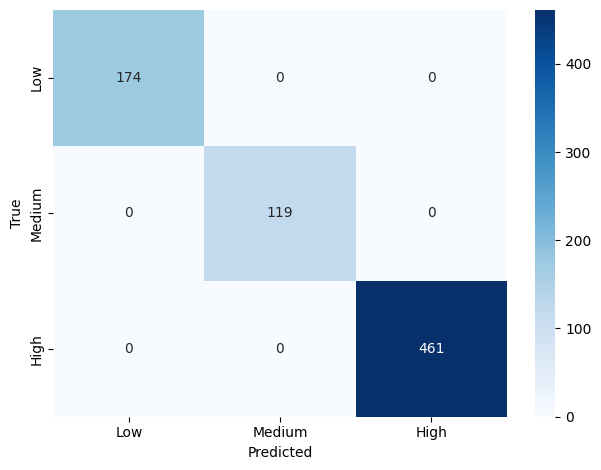

In [28]:
y_pred_class = clf.predict(X_test)

print(classification_report(y_test_class, y_pred_class, digits=3))

# Plot confusion matrix
cm = confusion_matrix(y_test_class, y_pred_class)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Low', 'Medium', 'High'],
            yticklabels=['Low', 'Medium', 'High'])
plt.title("")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


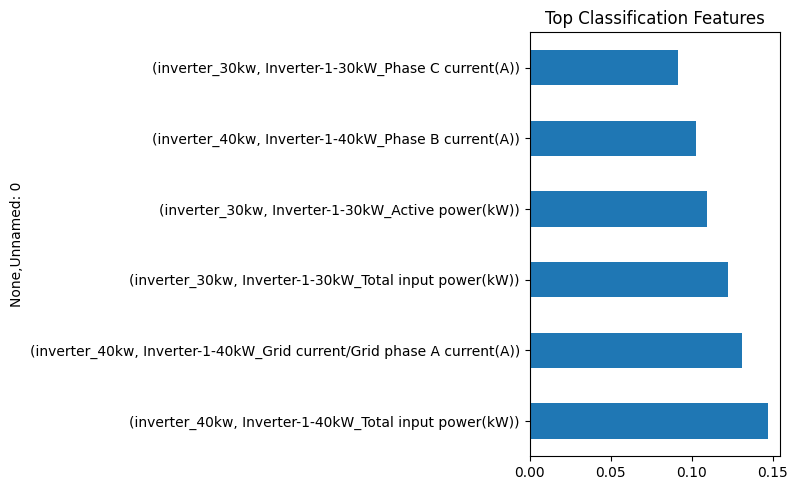

In [29]:
# Feature importance
importances = pd.Series(clf.feature_importances_, index=X.columns)
top = importances.nlargest(6)

top.plot(kind='barh', figsize=(8, 5), title="")
plt.tight_layout()
plt.show()


In [30]:
print(y_test_class.value_counts(normalize=True))

(inverter_40kw, Inverter-1-40kW_Active power(kW))
2    0.611406
0    0.230769
1    0.157825
Name: proportion, dtype: float64


In [31]:
np.unique(y_pred_class, return_counts=True)

(array([0, 1, 2]), array([174, 119, 461]))

In [32]:
y_class_future = y_class.shift(-12)  # predict 1 hour ahead ( 5 minute intervals therefore 5 * 12 = 60m)
mask = ~y_class_future.isna()
X_future = X[mask]
y_future_class = y_class_future[mask]

In [33]:
X_train_f, X_test_f, y_train_f, y_test_f = train_test_split(
    X_future, y_future_class, test_size=0.2, shuffle=False
)

clf_future = RandomForestClassifier(random_state=42)
clf_future.fit(X_train_f, y_train_f)


RandomForestClassifier(random_state=42)

In [34]:
y_pred_f = clf_future.predict(X_test_f)
print(classification_report(y_test_f, y_pred_f, digits=3))


              precision    recall  f1-score   support

         0.0      0.875     0.845     0.860       174
         1.0      0.173     0.819     0.285       116
         2.0      0.939     0.067     0.126       461

    accuracy                          0.364       751
   macro avg      0.662     0.577     0.423       751
weighted avg      0.806     0.364     0.320       751



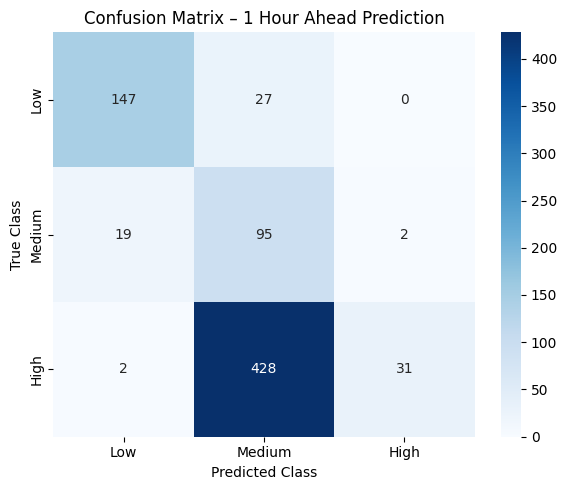

In [35]:
# Creating the confusion matrix
cm = confusion_matrix(y_test_f, y_pred_f)

# Plotting the heatmap / Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=["Low", "Medium", "High"],
            yticklabels=["Low", "Medium", "High"])
plt.title("Confusion Matrix – 1 Hour Ahead Prediction")
plt.xlabel("Predicted Class")
plt.ylabel("True Class")
plt.tight_layout()
plt.show()


## Time-Aware Cross-Validation for Regression (RandomForestRegressor + TimeSeriesSplit)

In [36]:
X_reg_cv = X.copy()
y_reg_cv = y.copy()

tscv = TimeSeriesSplit(n_splits=2)
mae_scorer = make_scorer(mean_absolute_error, greater_is_better=False)
r2_scorer = make_scorer(r2_score)

reg = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

r2_scores  = cross_val_score(reg, X_reg_cv, y_reg_cv, cv=tscv, scoring=r2_scorer, n_jobs=-1)
mae_scores = cross_val_score(reg, X_reg_cv, y_reg_cv, cv=tscv, scoring=mae_scorer, n_jobs=-1)

print("TimeSeriesSplit (Regression):")
print(f"  R²  per fold: {np.round(r2_scores, 4)} | mean={r2_scores.mean():.4f} ± {r2_scores.std():.4f}")
print(f"  MAE per fold: {np.round(-mae_scores, 4)} | mean={(-mae_scores).mean():.4f} ± {(-mae_scores).std():.4f}")


TimeSeriesSplit (Regression):
  R²  per fold: [0.9996 0.992 ] | mean=0.9958 ± 0.0038
  MAE per fold: [0.018  0.1157] | mean=0.0668 ± 0.0488


## Classification with Class Imbalance Handling (SMOTE + StratifiedKFold)

In [37]:
# Trying to import SMOTE
try:
    from imblearn.over_sampling import SMOTE
    from imblearn.pipeline import Pipeline
    has_imblearn = True
except Exception as e:
    has_imblearn = False
    print("imbalanced-learn not available. Install it with: pip install imbalanced-learn")

X_cls_cv = X.copy()
y_cls_cv = y_class.copy()

skf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
rf_cls = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)

if has_imblearn:
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler(with_mean=False)),
        ("smote", SMOTE(random_state=42, k_neighbors=5)),
        ("model", rf_cls),
    ])
else:
    from sklearn.pipeline import Pipeline as SkPipeline
    pipe = SkPipeline(steps=[
        ("scaler", StandardScaler(with_mean=False)),
        ("model", rf_cls),
    ])

y_pred_oof = cross_val_predict(pipe, X_cls_cv, y_cls_cv, cv=skf, n_jobs=-1)
acc  = accuracy_score(y_cls_cv, y_pred_oof)
f1m  = f1_score(y_cls_cv, y_pred_oof, average="macro")
bacc = balanced_accuracy_score(y_cls_cv, y_pred_oof)

print("StratifiedKFold (Classification with SMOTE-in-fold):")
print(f"  Accuracy       : {acc:.4f}")
print(f"  Macro F1-score : {f1m:.4f}")
print(f"  Balanced Acc   : {bacc:.4f}")
print("\nClassification Report:\n", classification_report(y_cls_cv, y_pred_oof, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_cls_cv, y_pred_oof))


StratifiedKFold (Classification with SMOTE-in-fold):
  Accuracy       : 0.9976
  Macro F1-score : 0.9976
  Balanced Acc   : 0.9976

Classification Report:
               precision    recall  f1-score   support

           0     0.9968    0.9976    0.9972      1243
           1     0.9968    0.9960    0.9964      1240
           2     0.9992    0.9992    0.9992      1284

    accuracy                         0.9976      3767
   macro avg     0.9976    0.9976    0.9976      3767
weighted avg     0.9976    0.9976    0.9976      3767

Confusion Matrix:
 [[1240    3    0]
 [   4 1235    1]
 [   0    1 1283]]


# One-hour-ahead classification: TimeSeriesSplit CV with in-fold SMOTE

In [38]:
# SMOTE
try:
    from imblearn.over_sampling import SMOTE
except Exception:
    raise RuntimeError("imbalanced-learn is required for SMOTE. Install it with: pip install imbalanced-learn")

# Data
X_fore = X_future.copy()
y_fore = y_future_class.copy()

# Encoding labels to 0..K-1
le = LabelEncoder()
y_enc = le.fit_transform(np.asarray(y_fore).ravel())

def _row_sel(A, idx):
    return A.iloc[idx] if hasattr(A, "iloc") else A[idx]

tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(n_estimators=500, random_state=42, n_jobs=-1)
smote = SMOTE(random_state=42, k_neighbors=5)

# Out-of-fold predictions; sentinel = -1
oof_pred = np.full(shape=y_enc.shape, fill_value=-1, dtype=int)
fold_stats = []

for fold, (tr, te) in enumerate(tscv.split(X_fore), 1):
    X_tr, y_tr = _row_sel(X_fore, tr), y_enc[tr]
    X_te, y_te = _row_sel(X_fore, te), y_enc[te]

    # SMOTE ONLY on training fold (no leakage)
    X_tr_bal, y_tr_bal = smote.fit_resample(X_tr, y_tr)

    rf.fit(X_tr_bal, y_tr_bal)
    pred = rf.predict(X_te).astype(int)
    oof_pred[te] = pred

    acc  = accuracy_score(y_te, pred)
    f1m  = f1_score(y_te, pred, average="macro")
    bacc = balanced_accuracy_score(y_te, pred)
    fold_stats.append((acc, f1m, bacc))
    print(f"[Fold {fold}]  Acc={acc:.4f}  MacroF1={f1m:.4f}  BalAcc={bacc:.4f}")

# Aggregating ONLY on tested indices (mask out "warm-up" region)
mask = (oof_pred != -1)
coverage = mask.mean()
print(f"\nOOF coverage: {coverage*100:.1f}% of samples were evaluated (early warm-up excluded).")

y_eval = y_enc[mask]
y_pred_eval = oof_pred[mask]

acc  = accuracy_score(y_eval, y_pred_eval)
f1m  = f1_score(y_eval, y_pred_eval, average="macro")
bacc = balanced_accuracy_score(y_eval, y_pred_eval)
print("\nTimeSeriesSplit (Forecast Classification, SMOTE in-fold):")
print(f"  Accuracy       : {acc:.4f}")
print(f"  Macro F1-score : {f1m:.4f}")
print(f"  Balanced Acc   : {bacc:.4f}")

# Reporting with original labels
y_eval_dec = le.inverse_transform(y_eval)
y_pred_dec = le.inverse_transform(y_pred_eval)
print("\nClassification Report (tested region only):\n", classification_report(y_eval_dec, y_pred_dec, digits=4))
print("Confusion Matrix (tested region only):\n", confusion_matrix(y_eval_dec, y_pred_dec))


[Fold 1]  Acc=0.7232  MacroF1=0.7220  BalAcc=0.7182
[Fold 2]  Acc=0.6080  MacroF1=0.6299  BalAcc=0.6311
[Fold 3]  Acc=0.6960  MacroF1=0.6511  BalAcc=0.7487
[Fold 4]  Acc=0.4352  MacroF1=0.3619  BalAcc=0.4342
[Fold 5]  Acc=0.7552  MacroF1=0.6648  BalAcc=0.6935

OOF coverage: 83.2% of samples were evaluated (early warm-up excluded).

TimeSeriesSplit (Forecast Classification, SMOTE in-fold):
  Accuracy       : 0.6435
  Macro F1-score : 0.6423
  Balanced Acc   : 0.6439

Classification Report (tested region only):
               precision    recall  f1-score   support

         0.0     0.7144    0.8050    0.7570      1010
         1.0     0.4684    0.5241    0.4947       977
         2.0     0.7673    0.6028    0.6752      1138

    accuracy                         0.6435      3125
   macro avg     0.6501    0.6439    0.6423      3125
weighted avg     0.6568    0.6435    0.6452      3125

Confusion Matrix (tested region only):
 [[813 190   7]
 [264 512 201]
 [ 61 391 686]]


In [39]:
# Data
X_fore = X_future.copy()
y_fore = y_future_class.copy()

# Encoding labels to integers (0..K-1)
le = LabelEncoder()
y_enc = le.fit_transform(np.asarray(y_fore).ravel())

def _row_sel(A, idx):
    return A.iloc[idx] if hasattr(A, "iloc") else A[idx]

tscv = TimeSeriesSplit(n_splits=5)
rf = RandomForestClassifier(
    n_estimators=500,
    class_weight="balanced",   # handling imbalance without synthetic samples
    random_state=42,
    n_jobs=-1
)

# Out-of-fold predictions with sentinel
oof_pred = np.full(y_enc.shape, -1, dtype=int)
fold_stats = []

for fold, (tr, te) in enumerate(tscv.split(X_fore), 1):
    X_tr, y_tr = _row_sel(X_fore, tr), y_enc[tr]
    X_te, y_te = _row_sel(X_fore, te), y_enc[te]

    rf.fit(X_tr, y_tr)
    pred = rf.predict(X_te).astype(int)
    oof_pred[te] = pred

    acc  = accuracy_score(y_te, pred)
    f1m  = f1_score(y_te, pred, average="macro")
    bacc = balanced_accuracy_score(y_te, pred)
    fold_stats.append((acc, f1m, bacc))
    print(f"[Fold {fold}]  Acc={acc:.4f}  MacroF1={f1m:.4f}  BalAcc={bacc:.4f}")

# Evaluating ONLY where OOF predictions exist (TimeSeriesSplit leaves early warm-up untested)
mask = (oof_pred != -1)
print(f"\nOOF coverage: {mask.mean()*100:.1f}% (earliest warm-up excluded)")

y_eval = y_enc[mask]
y_pred = oof_pred[mask]

acc  = accuracy_score(y_eval, y_pred)
f1m  = f1_score(y_eval, y_pred, average="macro")
bacc = balanced_accuracy_score(y_eval, y_pred)
print("\nTimeSeriesSplit (Forecast Classification, class_weight only):")
print(f"  Accuracy       : {acc:.4f}")
print(f"  Macro F1-score : {f1m:.4f}")
print(f"  Balanced Acc   : {bacc:.4f}")

# Detailed report with original labels (tested region only)
y_eval_dec = le.inverse_transform(y_eval)
y_pred_dec = le.inverse_transform(y_pred)
print("\nClassification Report:\n", classification_report(y_eval_dec, y_pred_dec, digits=4))
print("Confusion Matrix:\n", confusion_matrix(y_eval_dec, y_pred_dec))


[Fold 1]  Acc=0.7392  MacroF1=0.7418  BalAcc=0.7382
[Fold 2]  Acc=0.6688  MacroF1=0.6798  BalAcc=0.6751
[Fold 3]  Acc=0.6544  MacroF1=0.6149  BalAcc=0.7351
[Fold 4]  Acc=0.4320  MacroF1=0.3602  BalAcc=0.4319
[Fold 5]  Acc=0.7440  MacroF1=0.6608  BalAcc=0.6926

OOF coverage: 83.2% (earliest warm-up excluded)

TimeSeriesSplit (Forecast Classification, class_weight only):
  Accuracy       : 0.6477
  Macro F1-score : 0.6450
  Balanced Acc   : 0.6468

Classification Report:
               precision    recall  f1-score   support

         0.0     0.7214    0.8050    0.7609      1010
         1.0     0.4727    0.5046    0.4881       977
         2.0     0.7518    0.6309    0.6861      1138

    accuracy                         0.6477      3125
   macro avg     0.6486    0.6468    0.6450      3125
weighted avg     0.6547    0.6477    0.6484      3125

Confusion Matrix:
 [[813 190   7]
 [254 493 230]
 [ 60 360 718]]


## Z-score Threshold Validation Sweep

In [40]:
# Trying to derive the same series used for Z-score anomalies
series = None
if 'inverter_40kw_series' in globals():
    series = inverter_40kw_series
elif 'merged_df' in globals():
    try:
        series = merged_df[("inverter_40kw", "Inverter-1-40kW_Active power(kW)")].dropna()
    except Exception as e:
        series = None

if series is None:
    raise RuntimeError("Define the series used for Z-score anomalies, e.g., `inverter_40kw_series`.")

vals = series.values.astype(float)
zs = (vals - vals.mean()) / (vals.std(ddof=0) + 1e-12)

thresholds = np.arange(2.0, 4.5, 0.25)
rows = []
for thr in thresholds:
    frac_flagged = (np.abs(zs) >= thr).mean()
    rows.append({"z_threshold": thr, "frac_flagged": frac_flagged})

df_thr = pd.DataFrame(rows)
print(df_thr.to_string(index=False))


 z_threshold  frac_flagged
        2.00      0.064150
        2.25      0.050950
        2.50      0.042503
        2.75      0.033791
        3.00      0.027719
        3.25      0.020327
        3.50      0.013992
        3.75      0.004488
        4.00      0.003696
        4.25      0.001848


In [41]:
#  Statistical reporting with 95% bootstrap CIs
def bootstrap_ci(y_true, y_pred, metric_func, n_boot=1000, alpha=0.05, random_state=42):
    """Percentile bootstrap CI for a metric computed on paired (y_true, y_pred)."""
    rng = np.random.default_rng(random_state)
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    n = len(y_true)
    stats = []
    for _ in range(n_boot):
        idx = rng.integers(0, n, n)
        stats.append(metric_func(y_true[idx], y_pred[idx]))
    stats = np.asarray(stats)
    lo, hi = np.percentile(stats, [100*alpha/2, 100*(1-alpha/2)])
    return float(stats.mean()), float(lo), float(hi)

def _row_sel(A, idx):
    return A.iloc[idx] if hasattr(A, "iloc") else A[idx]

if 'X' in globals() and 'y' in globals():
    X_reg_cv = X.copy()
    y_reg_cv = np.asarray(y).ravel()

    tscv = TimeSeriesSplit(n_splits=5)
    rf_reg = RandomForestRegressor(n_estimators=300, random_state=42, n_jobs=-1)

    # Building OOF predictions
    oof_pred_reg = np.full(y_reg_cv.shape, np.nan, dtype=float)
    fold_stats = []
    for fold, (tr, te) in enumerate(tscv.split(X_reg_cv), 1):
        rf_reg.fit(_row_sel(X_reg_cv, tr), y_reg_cv[tr])
        pred = rf_reg.predict(_row_sel(X_reg_cv, te))
        oof_pred_reg[te] = pred
        r2  = r2_score(y_reg_cv[te], pred)
        mae = mean_absolute_error(y_reg_cv[te], pred)
        fold_stats.append((r2, mae))
        print(f"[REG fold {fold}] R²={r2:.4f}  MAE={mae:.4f}")

    mask = ~np.isnan(oof_pred_reg)
    print(f"\n[REG] OOF coverage: {mask.mean()*100:.1f}%")

    y_eval = y_reg_cv[mask]
    y_hat  = oof_pred_reg[mask]

    r2_mean, r2_lo, r2_hi   = bootstrap_ci(y_eval, y_hat, r2_score)
    mae_mean, mae_lo, mae_hi = bootstrap_ci(y_eval, y_hat, mean_absolute_error)

    print("\n[REG] OOF metrics with 95% bootstrap CI:")
    print(f"  R²  = {r2_mean:.4f} [{r2_lo:.4f}, {r2_hi:.4f}]")
    print(f"  MAE = {mae_mean:.4f} [{mae_lo:.4f}, {mae_hi:.4f}] kW")
else:
    print("[REG] Skipped: variables X and y not found.")

if 'X_future' in globals() and 'y_future_class' in globals():
    X_fore = X_future.copy()
    y_fore = pd.Series(y_future_class).copy()

    le = LabelEncoder()
    y_enc = le.fit_transform(np.asarray(y_fore).ravel())

    tscv = TimeSeriesSplit(n_splits=5)
    rf_cls = RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    oof_pred = np.full(y_enc.shape, -1, dtype=int)
    fold_stats = []
    for fold, (tr, te) in enumerate(tscv.split(X_fore), 1):
        rf_cls.fit(_row_sel(X_fore, tr), y_enc[tr])
        pred = rf_cls.predict(_row_sel(X_fore, te)).astype(int)
        oof_pred[te] = pred

        acc  = accuracy_score(y_enc[te], pred)
        f1m  = f1_score(y_enc[te], pred, average="macro")
        bacc = balanced_accuracy_score(y_enc[te], pred)
        fold_stats.append((acc, f1m, bacc))
        print(f"[FORE fold {fold}] Acc={acc:.4f}  MacroF1={f1m:.4f}  BalAcc={bacc:.4f}")

    mask = (oof_pred != -1)
    print(f"\n[FORE] OOF coverage: {mask.mean()*100:.1f}%")

    y_eval = y_enc[mask]
    y_hat  = oof_pred[mask]

    acc_mean, acc_lo, acc_hi = bootstrap_ci(y_eval, y_hat, accuracy_score)
    f1m_mean, f1m_lo, f1m_hi = bootstrap_ci(y_eval, y_hat, lambda y,p: f1_score(y, p, average="macro"))

    print("\n[FORE] OOF metrics with 95% bootstrap CI (class_weight only):")
    print(f"  Accuracy = {acc_mean:.4f} [{acc_lo:.4f}, {acc_hi:.4f}]")
    print(f"  Macro F1 = {f1m_mean:.4f} [{f1m_lo:.4f}, {f1m_hi:.4f}]")
else:
    print("[FORE] Skipped: variables X_future and/or y_future_class not found.")

# Static classification
if 'X' in globals() and 'y_class' in globals():
    X_cls = X.copy()
    y_cls = pd.Series(y_class).copy()

    le2 = LabelEncoder()
    y_enc2 = le2.fit_transform(np.asarray(y_cls).ravel())

    tscv2 = TimeSeriesSplit(n_splits=5)
    rf_cls2 = RandomForestClassifier(
        n_estimators=500,
        class_weight="balanced",
        random_state=42,
        n_jobs=-1
    )

    oof_pred2 = np.full(y_enc2.shape, -1, dtype=int)
    for fold, (tr, te) in enumerate(tscv2.split(X_cls), 1):
        rf_cls2.fit(_row_sel(X_cls, tr), y_enc2[tr])
        pred = rf_cls2.predict(_row_sel(X_cls, te)).astype(int)
        oof_pred2[te] = pred
        acc  = accuracy_score(y_enc2[te], pred)
        f1m  = f1_score(y_enc2[te], pred, average="macro")
        bacc = balanced_accuracy_score(y_enc2[te], pred)
        print(f"[STATIC fold {fold}] Acc={acc:.4f}  MacroF1={f1m:.4f}  BalAcc={bacc:.4f}")

    mask2 = (oof_pred2 != -1)
    print(f"\n[STATIC] OOF coverage: {mask2.mean()*100:.1f}%")

    y_eval2 = y_enc2[mask2]
    y_hat2  = oof_pred2[mask2]

    acc2_mean, acc2_lo, acc2_hi = bootstrap_ci(y_eval2, y_hat2, accuracy_score)
    f1m2_mean, f1m2_lo, f1m2_hi = bootstrap_ci(y_eval2, y_hat2, lambda y,p: f1_score(y,p,average="macro"))

    print("\n[STATIC] OOF metrics with 95% bootstrap CI:")
    print(f"  Accuracy = {acc2_mean:.4f} [{acc2_lo:.4f}, {acc2_hi:.4f}]")
    print(f"  Macro F1 = {f1m2_mean:.4f} [{f1m2_lo:.4f}, {f1m2_hi:.4f}]")
else:
    print("[STATIC] Skipped: variables X and/or y_class not found.")


[REG fold 1] R²=0.9299  MAE=0.3335
[REG fold 2] R²=0.9995  MAE=0.0303
[REG fold 3] R²=1.0000  MAE=0.0059
[REG fold 4] R²=0.9978  MAE=0.0394
[REG fold 5] R²=0.9958  MAE=0.1080

[REG] OOF coverage: 83.2%

[REG] OOF metrics with 95% bootstrap CI:
  R²  = 0.9867 [0.9820, 0.9908]
  MAE = 0.1035 [0.0844, 0.1256] kW
[FORE fold 1] Acc=0.7392  MacroF1=0.7418  BalAcc=0.7382
[FORE fold 2] Acc=0.6688  MacroF1=0.6798  BalAcc=0.6751
[FORE fold 3] Acc=0.6544  MacroF1=0.6149  BalAcc=0.7351
[FORE fold 4] Acc=0.4320  MacroF1=0.3602  BalAcc=0.4319
[FORE fold 5] Acc=0.7440  MacroF1=0.6608  BalAcc=0.6926

[FORE] OOF coverage: 83.2%

[FORE] OOF metrics with 95% bootstrap CI (class_weight only):
  Accuracy = 0.6479 [0.6310, 0.6650]
  Macro F1 = 0.6451 [0.6293, 0.6612]
[STATIC fold 1] Acc=0.9936  MacroF1=0.9930  BalAcc=0.9926
[STATIC fold 2] Acc=0.9968  MacroF1=0.9968  BalAcc=0.9968
[STATIC fold 3] Acc=0.9968  MacroF1=0.9977  BalAcc=0.9976
[STATIC fold 4] Acc=1.0000  MacroF1=1.0000  BalAcc=1.0000
[STATIC fold

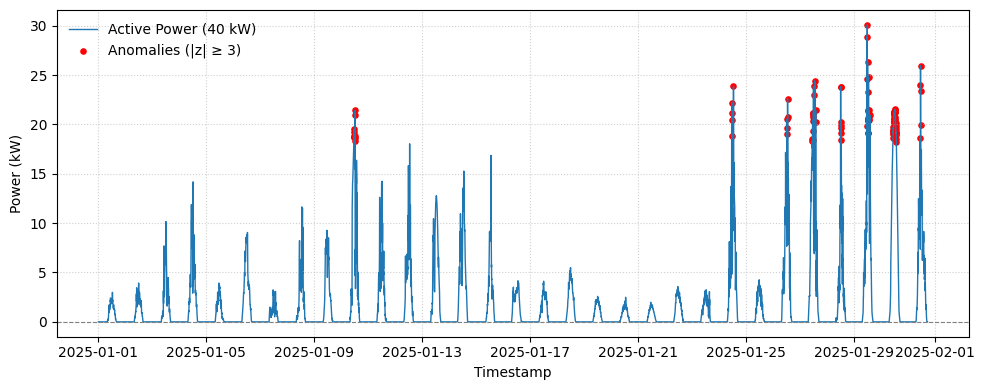

In [42]:
if "inverter_40kw_series" in globals():
    s = inverter_40kw_series.dropna()
elif "merged_df" in globals():
    s = merged_df[("inverter_40kw", "Inverter-1-40kW_Active power(kW)")].dropna()
else:
    raise RuntimeError("Provide inverter_40kw_series or merged_df first.")

# Z-scores and threshold
Z_THR = 3.0
vals = s.values.astype(float)
zs = (vals - vals.mean()) / (vals.std(ddof=0) + 1e-12)
anom = np.abs(zs) >= Z_THR

plt.figure(figsize=(10, 4))
plt.plot(s.index, s.values, lw=1.0, label="Active Power (40 kW)")
plt.scatter(s.index[anom], s.values[anom], s=14, c="r", label=f"Anomalies (|z| ≥ {Z_THR:.0f})")
plt.axhline(0, color="gray", lw=0.8, linestyle="--")
plt.xlabel("Timestamp")
plt.ylabel("Power (kW)")
plt.legend(frameon=False)
plt.grid(True, linestyle=":", alpha=0.6)
plt.tight_layout()
plt.show()
